In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression, PoissonRegressor, Lasso, Ridge
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, LinearSVC
from sklearn.metrics import accuracy_score, r2_score, f1_score, mean_squared_error,median_absolute_error ,mean_absolute_error, max_error, explained_variance_score, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from yellowbrick.model_selection import FeatureImportances
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import seaborn as sns

In [2]:
df = pd.read_csv('data_by_pairs.csv')
df_dummy = pd.read_csv('data_tennis_prev.xls')
df_mean = pd.read_csv('data_mean_prev.xls')
df_dif = pd.read_csv('data_dif.csv')


In [3]:
df_mean['age_dif'] = df_mean['age_dif'] ** 2

In [4]:
reg = [ LinearRegression(), PoissonRegressor(), AdaBoostRegressor(), Lasso(), DecisionTreeRegressor(), SVR(), Ridge(), CatBoostRegressor(iterations=100), LGBMRegressor(), XGBRegressor()]
cl = [LogisticRegression(), CatBoostClassifier(iterations=100), RandomForestClassifier(), MLPClassifier(), AdaBoostClassifier(), LinearSVC(), LGBMClassifier(), XGBClassifier()]

In [5]:
one_time = list(df.dropna().reset_index()[df.number<2][['name1', 'name2']].index)

C:\Users\Masha\AppData\Local\Temp\ipykernel_548\724552594.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  one_time = list(df.dropna().reset_index()[df.number<2][['name1', 'name2']].index)


In [6]:
df_mean = df_mean.drop(one_time)

C:\Users\Masha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


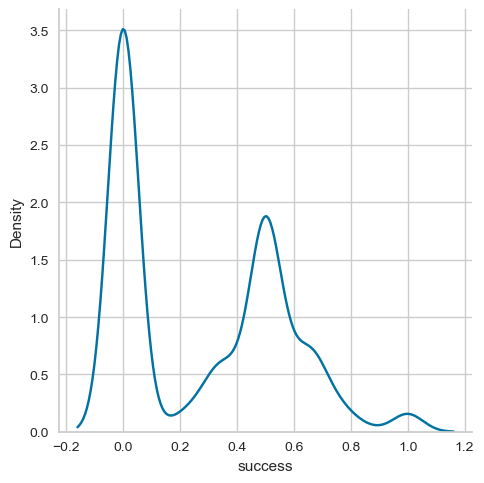

In [7]:
sns.displot(df_mean.success, kind='kde')

In [8]:
df_mean.success.describe()

count    4376.000000
mean        0.277032
std         0.287741
min         0.000000
25%         0.000000
50%         0.250000
75%         0.500000
max         1.000000
Name: success, dtype: float64

In [9]:
df_mean[['rank', 'age_dif', 'height', 'Ace', 'DF', "BP_saved", "Ace_against", 'BP_won', 'Return_won', 'Point_dominance', 'Game_time']].describe()

,rank,age_dif,height,Ace,DF,BP_saved,Ace_against,BP_won,Return_won,Point_dominance,Game_time
count,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000
mean,296.786124,19.661860,185.631170,6.902994,4.218739,58.597463,7.501691,37.656787,35.659906,0.928188,4.093058
std,390.616067,41.194574,4.790507,2.752327,1.131259,4.992252,1.728489,6.197376,2.926846,0.094278,0.313408
min,2.500000,0.000000,169.000000,0.250000,1.350000,17.400000,0.400000,0.000000,14.100000,0.415000,1.425000
25%,82.000000,0.943333,182.500000,4.950000,3.450000,57.100000,6.350000,36.400000,34.450000,0.885000,3.940000
50%,166.000000,5.470028,185.500000,6.550000,4.050000,59.350000,7.450000,38.650000,36.100000,0.935000,4.115000
75%,325.125000,19.653839,189.000000,8.400000,4.750000,61.200000,8.550000,40.350000,37.400000,0.985000,4.280000
max,2500.000000,568.403039,207.000000,22.350000,13.600000,77.750000,20.100000,75.000000,42.350000,1.300000,4.980000


In [10]:
conditions = [
    (df_mean['success'] == 0),
    ((df_mean['success'] > 0) & (df_mean['success'] <=0.5)),
    (df_mean['success'] > 0.5)]
choices = [0, 1, 2]
df_mean['success_cl'] = np.select(conditions, choices, default=0)

In [11]:
df_mean.success_cl.value_counts()

success_cl
0    2072
1    1521
2     783
Name: count, dtype: int64

In [12]:
df = df.drop(['hand1', 'hand2', 'ioc1', 'ioc2'], axis=1)

In [13]:
df_mean.describe()

,success,success_cl,rank,hand,age_dif,country,height,relatives,Ace,DF,BP_saved,Ace_against,BP_won,Return_won,Point_dominance,Serve_rating,Game_time
count,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000,4376.000000
mean,0.277032,0.705439,296.786124,0.765768,19.661860,0.333181,185.631170,0.002971,6.902994,4.218739,58.597463,7.501691,37.656787,35.659906,0.928188,313.524452,4.093058
std,0.287741,0.752187,390.616067,0.423566,41.194574,0.471404,4.790507,0.054430,2.752327,1.131259,4.992252,1.728489,6.197376,2.926846,0.094278,18.412529,0.313408
min,0.000000,0.000000,2.500000,0.000000,0.000000,0.000000,169.000000,0.000000,0.250000,1.350000,17.400000,0.400000,0.000000,14.100000,0.415000,223.500000,1.425000
25%,0.000000,0.000000,82.000000,1.000000,0.943333,0.000000,182.500000,0.000000,4.950000,3.450000,57.100000,6.350000,36.400000,34.450000,0.885000,305.000000,3.940000
50%,0.250000,1.000000,166.000000,1.000000,5.470028,0.000000,185.500000,0.000000,6.550000,4.050000,59.350000,7.450000,38.650000,36.100000,0.935000,315.500000,4.115000
75%,0.500000,1.000000,325.125000,1.000000,19.653839,1.000000,189.000000,0.000000,8.400000,4.750000,61.200000,8.550000,40.350000,37.400000,0.985000,325.000000,4.280000
max,1.000000,2.000000,2500.000000,1.000000,568.403039,1.000000,207.000000,1.000000,22.350000,13.600000,77.750000,20.100000,75.000000,42.350000,1.300000,384.500000,4.980000


# Regression 

In [995]:
y = df_dummy['success']
X = df_dummy.drop(['success','success_cl' ,'name1', 'name2', 'rank', 'Serve_rating', ], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [581]:
for model in reg:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model, r2_score(y_test, y_pred))

LinearRegression() 0.10969785860710646
PoissonRegressor() 0.1936240037340594
AdaBoostRegressor() 0.20375719842760898
Lasso() 0.0920828916897678
DecisionTreeRegressor() -0.49286330362853525


C:\Users\Masha\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


SVR() 0.18555763869636255
Ridge() 0.10911456352626825
Learning rate set to 0.315477
0:	learn: 0.7186740	total: 2.28ms	remaining: 226ms
1:	learn: 0.6932671	total: 4.48ms	remaining: 220ms
2:	learn: 0.6785718	total: 6.76ms	remaining: 219ms
3:	learn: 0.6689819	total: 8.73ms	remaining: 210ms
4:	learn: 0.6633240	total: 10.6ms	remaining: 202ms
5:	learn: 0.6591511	total: 12.5ms	remaining: 196ms
6:	learn: 0.6555151	total: 14.5ms	remaining: 193ms
7:	learn: 0.6508496	total: 16.6ms	remaining: 191ms
8:	learn: 0.6475671	total: 18.7ms	remaining: 189ms
9:	learn: 0.6451576	total: 20.7ms	remaining: 186ms
10:	learn: 0.6426597	total: 22.6ms	remaining: 183ms
11:	learn: 0.6404565	total: 24.7ms	remaining: 181ms
12:	learn: 0.6387965	total: 26.8ms	remaining: 180ms
13:	learn: 0.6368111	total: 28.8ms	remaining: 177ms
14:	learn: 0.6351005	total: 30.9ms	remaining: 175ms
15:	learn: 0.6323952	total: 32.8ms	remaining: 172ms
16:	learn: 0.6298171	total: 34.8ms	remaining: 170ms
17:	learn: 0.6293376	total: 36.8ms	remaini

# Classfication dummy

In [1041]:
y = df_dummy['success_cl']
X = df_dummy.drop(['success','success_cl' ,'name1', 'name2', 'rank', 'Serve_rating'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [1042]:
for model in cl:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model, accuracy_score(y_test, y_pred))

LogisticRegression() 0.5274086378737541
Learning rate set to 0.5
0:	learn: 0.9838217	total: 21ms	remaining: 2.07s
1:	learn: 0.9355695	total: 24.9ms	remaining: 1.22s
2:	learn: 0.9143618	total: 27.4ms	remaining: 887ms
3:	learn: 0.9054676	total: 30ms	remaining: 721ms
4:	learn: 0.8944641	total: 33.6ms	remaining: 638ms
5:	learn: 0.8886972	total: 37.4ms	remaining: 586ms
6:	learn: 0.8815264	total: 41ms	remaining: 545ms
7:	learn: 0.8719449	total: 44.6ms	remaining: 513ms
8:	learn: 0.8654740	total: 48.6ms	remaining: 492ms
9:	learn: 0.8584279	total: 52.5ms	remaining: 472ms
10:	learn: 0.8532344	total: 56ms	remaining: 453ms
11:	learn: 0.8489062	total: 59.6ms	remaining: 437ms
12:	learn: 0.8431142	total: 63.2ms	remaining: 423ms
13:	learn: 0.8397689	total: 66.8ms	remaining: 410ms
14:	learn: 0.8363406	total: 70.3ms	remaining: 398ms
15:	learn: 0.8305116	total: 73.9ms	remaining: 388ms
16:	learn: 0.8261266	total: 78ms	remaining: 381ms
17:	learn: 0.8212745	total: 81.3ms	remaining: 370ms
18:	learn: 0.813760

# Regression Mean

In [115]:
y = df_mean['success']
X = df_mean.drop(['success','success_cl' ,'name1', 'name2', 'rank', 'Serve_rating'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [116]:
for model in reg:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model, r2_score(y_test, y_pred))

LinearRegression() 0.11667236742979359
PoissonRegressor() 0.20348544281956615


C:\Users\Masha\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


AdaBoostRegressor() 0.27547183795443553
Lasso() 0.0879029899252246
DecisionTreeRegressor() -0.46179946918173664
SVR() 0.19230181441806726
Ridge() 0.11613495494144488
Learning rate set to 0.315477
0:	learn: 0.2683378	total: 177ms	remaining: 17.5s
1:	learn: 0.2587252	total: 184ms	remaining: 9.02s
2:	learn: 0.2520827	total: 190ms	remaining: 6.15s
3:	learn: 0.2479166	total: 196ms	remaining: 4.71s
4:	learn: 0.2454619	total: 203ms	remaining: 3.85s
5:	learn: 0.2436908	total: 210ms	remaining: 3.3s
6:	learn: 0.2424597	total: 217ms	remaining: 2.88s
7:	learn: 0.2411992	total: 223ms	remaining: 2.56s
8:	learn: 0.2402579	total: 229ms	remaining: 2.32s
9:	learn: 0.2394652	total: 236ms	remaining: 2.12s
10:	learn: 0.2387255	total: 242ms	remaining: 1.96s
11:	learn: 0.2377583	total: 249ms	remaining: 1.82s
12:	learn: 0.2373917	total: 254ms	remaining: 1.7s
13:	learn: 0.2365333	total: 261ms	remaining: 1.6s
14:	learn: 0.2356958	total: 267ms	remaining: 1.51s
15:	learn: 0.2350411	total: 273ms	remaining: 1.43s
1

# Classification Mean

In [14]:
y = df_mean['success_cl']
X = df_mean.drop(['success','success_cl' ,'name1', 'name2', 'rank', 'Serve_rating'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
for model in cl:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model, accuracy_score(y_test, y_pred))

C:\Users\Masha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression() 0.5176470588235295
Learning rate set to 0.5
0:	learn: 0.9843616	total: 176ms	remaining: 17.4s
1:	learn: 0.9465298	total: 191ms	remaining: 9.36s
2:	learn: 0.9156225	total: 207ms	remaining: 6.68s
3:	learn: 0.8996133	total: 221ms	remaining: 5.3s
4:	learn: 0.8863352	total: 236ms	remaining: 4.47s
5:	learn: 0.8767575	total: 249ms	remaining: 3.9s
6:	learn: 0.8717836	total: 260ms	remaining: 3.46s
7:	learn: 0.8635854	total: 272ms	remaining: 3.13s
8:	learn: 0.8546293	total: 285ms	remaining: 2.88s
9:	learn: 0.8487679	total: 296ms	remaining: 2.66s
10:	learn: 0.8450953	total: 309ms	remaining: 2.5s
11:	learn: 0.8390467	total: 321ms	remaining: 2.35s
12:	learn: 0.8376184	total: 333ms	remaining: 2.23s
13:	learn: 0.8277455	total: 347ms	remaining: 2.13s
14:	learn: 0.8225278	total: 359ms	remaining: 2.03s
15:	learn: 0.8172152	total: 372ms	remaining: 1.95s
16:	learn: 0.8110711	total: 384ms	remaining: 1.88s
17:	learn: 0.8057370	total: 398ms	remaining: 1.81s
18:	learn: 0.8007757	total: 41

C:\Users\Masha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC() 0.4955017301038062
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1929
[LightGBM] [Info] Number of data points in the train set: 2931, number of used features: 12
[LightGBM] [Info] Start training from score -0.742449
[LightGBM] [Info] Start training from score -1.068368
[LightGBM] [Info] Start training from score -1.712111
LGBMClassifier() 0.5301038062283737
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=Non

# Pipeline

In [18]:
y_full = df['success']
X_full = df.drop(['success','name1', 'name2', 'rank1', 'Serve_rating1', 'Serve_rating2', 'rank2'], axis=1)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.33, random_state=42)

In [19]:
pca = PCA(5)
reg = LGBMRegressor(colsample_bytree=0.9 ,max_depth=4, learning_rate=0.1,min_child_samples=10,
              n_estimators=80, objective='regression', random_state=100,
              subsample=0.7, num_leaves=10)
cl = MLPClassifier()
scaler = StandardScaler()
pipe = Pipeline(steps=[("scaler", scaler), ("classficator", reg)])
y = df_mean['success']
X = df_mean.drop(['success','success_cl' ,'name1', 'name2', 'Serve_rating'], axis=1)
#X = df_mean[['age_dif', 'Ace', 'Game_time', 'height', 'DF', 'relatives']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
yd = df_mean['success_cl']
Xd = df_mean.drop(['success','success_cl' ,'name1', 'name2', 'Serve_rating'], axis=1)
#X = df_mean[['age_dif', 'Ace', 'Game_time', 'height', 'DF', 'relatives']]
X_traind, X_testd, y_traind, y_testd = train_test_split(Xd, yd, test_size=0.33, random_state=42)

In [21]:
pipe.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2263
[LightGBM] [Info] Number of data points in the train set: 2931, number of used features: 14
[LightGBM] [Info] Start training from score 0.277370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Pipeline(steps=[('scaler', StandardScaler()),
                ('classficator',
                 LGBMRegressor(colsample_bytree=0.9, max_depth=4,
                               min_child_samples=10, n_estimators=80,
                               num_leaves=10, objective='regression',
                               random_state=100, subsample=0.7))])

In [22]:
y_pred = pipe.predict(X_test)

In [23]:
 y_pred = pipe.predict(X_test)
 print('MSE:',mean_squared_error(y_test, y_pred, squared=True))
 print('RMSE:',mean_squared_error(y_test, y_pred, squared=False))
 print('MAE:',mean_absolute_error(y_test, y_pred))
 print('MedAE:',median_absolute_error(y_test, y_pred))
 print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
 print('r2:', r2_score(y_test, y_pred))

MSE: 0.05420074942744434
RMSE: 0.23281054406414745
MAE: 0.1980842101343137
MedAE: 0.189670526894469
Explained Variance Score: 0.33079358499808176
r2: 0.3307935567723501


## Feature Importance

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2184
[LightGBM] [Info] Number of data points in the train set: 2931, number of used features: 13
[LightGBM] [Info] Start training from score -0.742449
[LightGBM] [Info] Start training from score -1.068368
[LightGBM] [Info] Start training from score -1.712111
age_dif            1090
rank                987
Game_time           864
Ace                 847
BP_saved            834
Return_won          817
BP_won              796
Ace_against         787
DF                  735
Point_dominance     566
height              509
country             111
hand                 57
relatives             0
dtype: int32


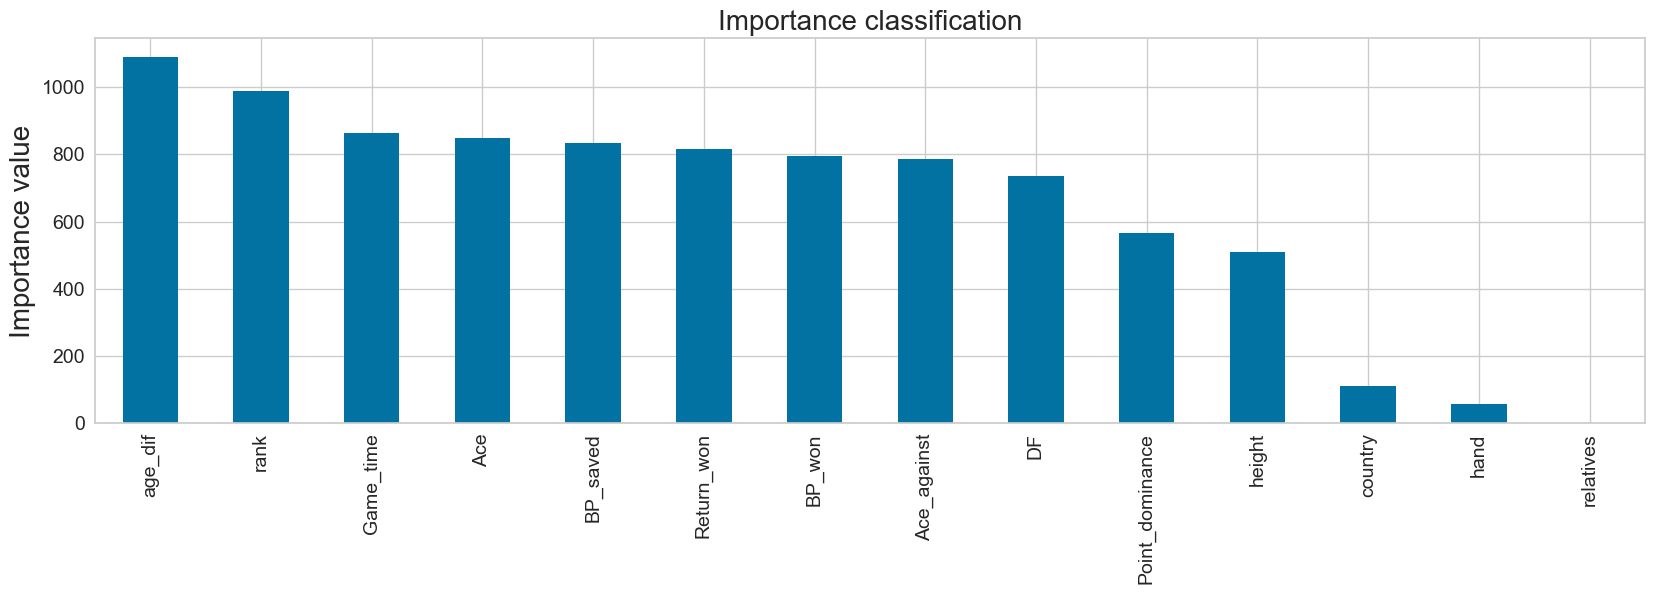

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2184
[LightGBM] [Info] Number of data points in the train set: 2931, number of used features: 13
[LightGBM] [Info] Start training from score 0.277370


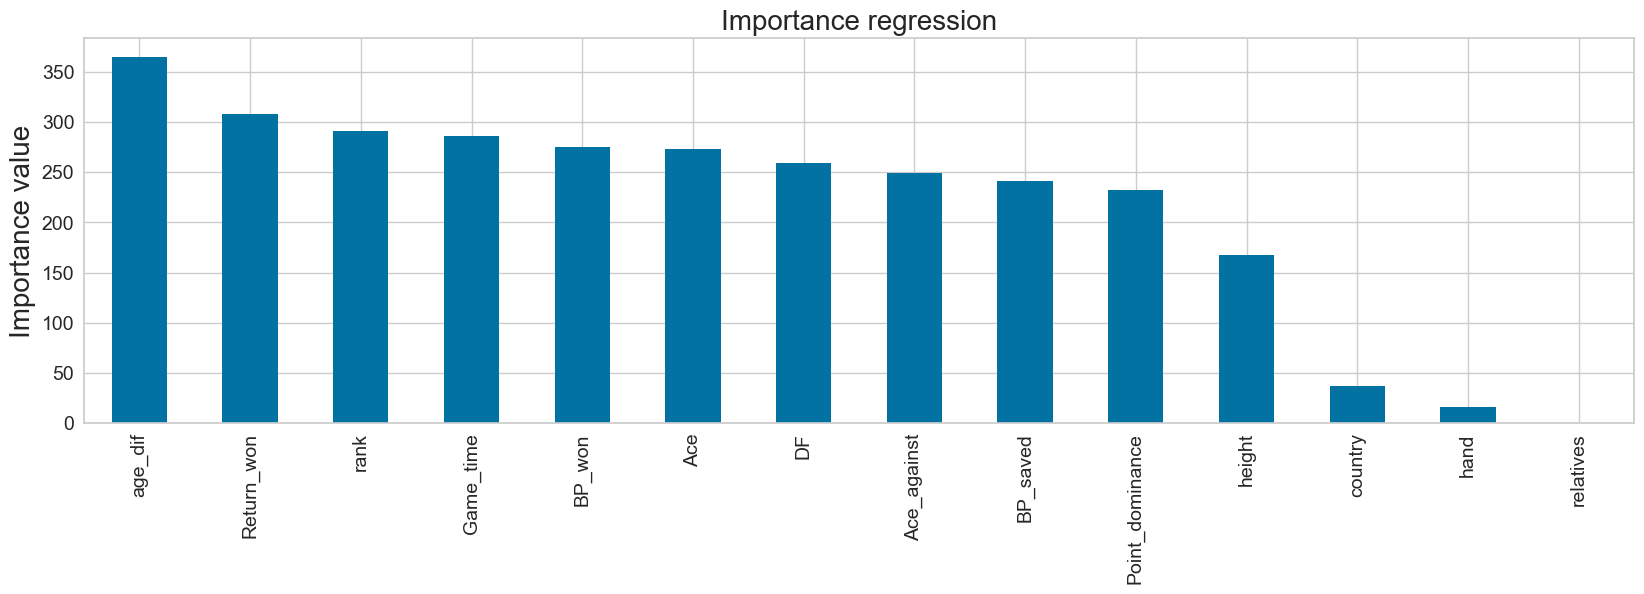

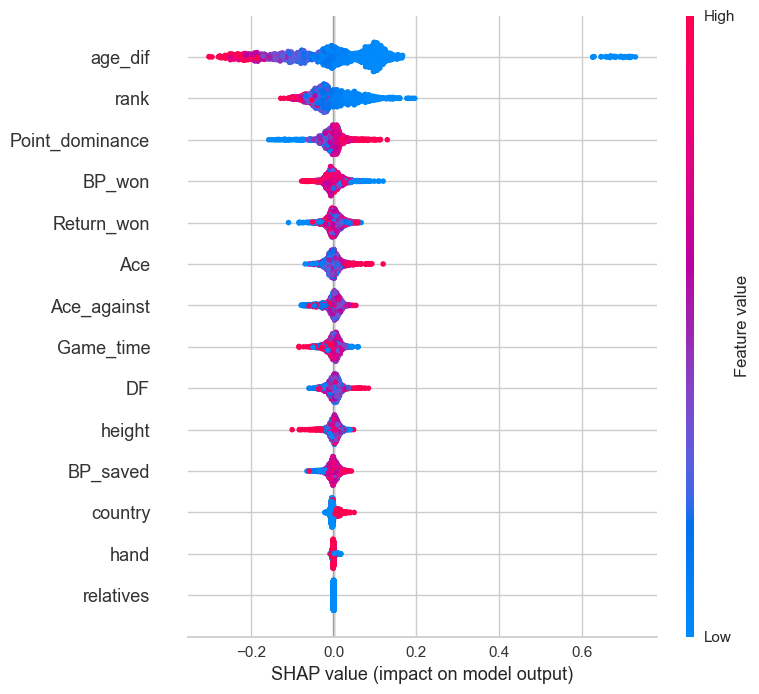

In [26]:
import shap
cl = LGBMClassifier()
cl.fit(X_traind, y_traind)
importance = pd.Series(
    data = cl.feature_importances_,
    index = X_traind.columns,
)
importance.sort_values(inplace=True, ascending=False)
print(importance)
importance.plot.bar(figsize=(20,5), fontsize=14)
plt.title("Importance classification", fontsize=20)
plt.ylabel("Importance value", fontsize=20)
plt.show()

reg = LGBMRegressor()
reg.fit(X_train, y_train)
importance = pd.Series(
    data = reg.feature_importances_,
    index = X_train.columns,
)
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(20,5), fontsize=14)
plt.title("Importance regression", fontsize=20)
plt.ylabel("Importance value", fontsize=20)
plt.show()




X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_importance)
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

In [27]:
  param_grid = {
      'learning_rate': [0.1, 0.01],
     'n_estimators': [50, 100, 150],
      'max_depth': [4, 6],
      'colsample_bytree': [0.7, 0.8, 0.9],
      'subsample': [0.7, 0.8, 0.9],
      'min_child_samples': [1,5, 10]
  }
  
  # Step 2: Initialize LGBMRegressor estimattor
  estimator = LGBMRegressor(objective='regression', 
                                random_state=101)
  
  # Step 3: Initalise Grid Search with 3-fold cross validation and fit model
  model = GridSearchCV(estimator=estimator, 
                       param_grid=param_grid,
                       cv=3, 
                       n_jobs=-1, 
                       scoring='neg_root_mean_squared_error')
  model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2186
[LightGBM] [Info] Number of data points in the train set: 2931, number of used features: 14
[LightGBM] [Info] Start training from score 0.277370
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

GridSearchCV(cv=3,
             estimator=LGBMRegressor(objective='regression', random_state=101),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.1, 0.01], 'max_depth': [4, 6],
                         'min_child_samples': [1, 5, 10],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_root_mean_squared_error')

LGBMRegressor(colsample_bytree=0.8, max_depth=4, min_child_samples=10,
              n_estimators=50, objective='regression', random_state=101,
              subsample=0.7)


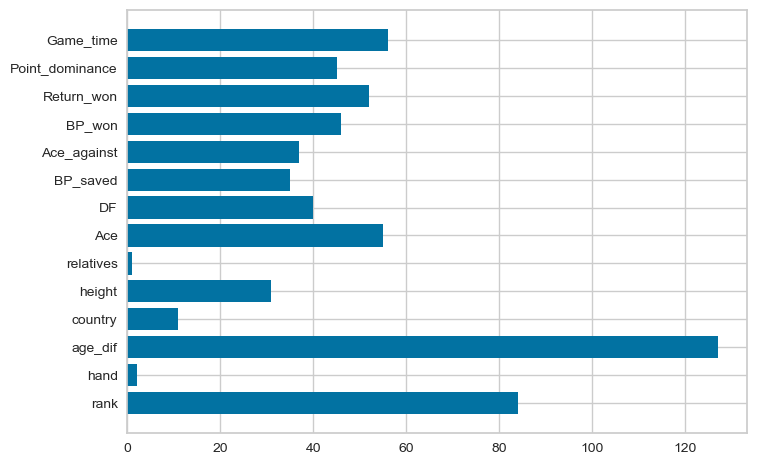

In [28]:

  best_params = model.best_estimator_
  print(best_params)
  
  features = X_train.columns
  importance_values = best_params.feature_importances_
  
  plt.barh(y=range(len(features)),
           width=importance_values,
           tick_label=features)
  plt.show()

In [29]:
## OLS Regerssion

In [1024]:
from statsmodels.api import OLS
import statsmodels.api as sm
OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                success   R-squared (uncentered):                   0.547
Model:                            OLS   Adj. R-squared (uncentered):              0.546
Method:                 Least Squares   F-statistic:                              627.2
Date:                Tue, 14 May 2024   Prob (F-statistic):                        0.00
Time:                        23:22:50   Log-Likelihood:                         -768.86
No. Observations:                7295   AIC:                                      1566.
Df Residuals:                    7281   BIC:                                      1662.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
rank            -9.159e-05   8.52e-06    -10.745      0.000      -0.000   -7.49e-05
hand               -0.0111      0.007     -1.499      0.134      -0.026       0.003
age_dif            -0.0021   7.47e-05    -27.836      0.000      -0.002      -0.002
country             0.0114      0.007      1.676      0.094      -0.002       0.025
height              0.0018      0.000      5.151      0.000       0.001       0.003
relatives           0.1769      0.053      3.333      0.001       0.073       0.281
Ace              8.917e-05      0.002      0.045      0.964      -0.004       0.004
DF                  0.0096      0.003      3.120      0.002       0.004       0.016
BP_saved           -0.0004      0.001     -0.531      0.596      -0.002       0.001
Ace_against        -0.0032      0.002     -1.644      0.100      -0.007       0.001
BP_won             -0.0025      0.001     -3.963      0.000      -0.004      -0.001
Return_won         -0.0018      0.002     -0.837      0.402      -0.006       0.002
Point_dominance     0.3070      0.075      4.074      0.000       0.159       0.455
Game_time          -0.0269      0.011     -2.473      0.013      -0.048      -0.006
==============================================================================
Omnibus:                      999.418   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              362.118
Skew:                           0.327   Prob(JB):                     2.33e-79
Kurtosis:                       2.127   Cond. No.                     1.19e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Neural Network

In [20]:
y_np = df_mean['success_cl']
X_np = df_mean.drop(['success', 'success_cl','name1', 'name2', 'Serve_rating'], axis=1)
#X = df_mean[['age_dif', 'Ace', 'Game_time', 'height', 'DF', 'relatives']]
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_np, y_np, test_size=0.33, random_state=42)

In [21]:
import sklearn

C:\Users\Masha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.3888 - loss: 1.2012 - val_accuracy: 0.4585 - val_loss: 0.9979
Epoch 2/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4724 - loss: 0.9860 - val_accuracy: 0.4950 - val_loss: 0.9553
Epoch 3/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4815 - loss: 0.9773 - val_accuracy: 0.4946 - val_loss: 0.9699
Epoch 4/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4866 - loss: 0.9669 - val_accuracy: 0.5208 - val_loss: 0.9358
Epoch 5/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4900 - loss: 0.9745 - val_accuracy: 0.5357 - val_loss: 0.9224
Epoch 6/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4903 - loss: 0.9634 - val_accuracy: 0.4863 - val_loss: 0.9695
Epoch 7/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4963 - loss: 0.9726 - val_accuracy: 0.4817 - val_loss: 0.9767
Epoch 8/50
489/489 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5021 - loss: 0.9655 - val_accuracy: 0

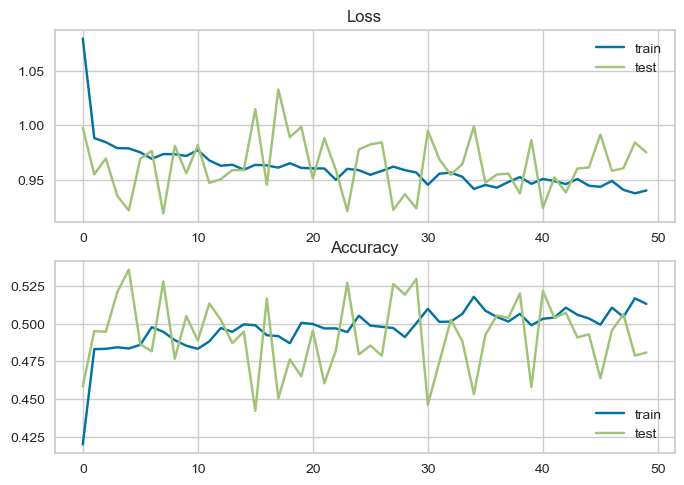

In [22]:
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
scaler = StandardScaler()
X_np = scaler.fit_transform(X_np)

# Splitting the dataset into training and testing sets
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_np, y_np, test_size=0.33, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_np.values), y=y_train_np.values)
class_weight_dict = dict(enumerate(class_weights))
# Building the neural network model
model = keras.Sequential([
    layers.Dense(64, input_dim=X_train_np.shape[1], activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax') 
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_np, y_train_np.values, epochs=50, batch_size=10, validation_data=(X_test_np, y_test_np), class_weight=class_weight_dict)


_, train_acc = model.evaluate(X_train_np, y_train_np, verbose=0)
what, test_acc = model.evaluate(X_test_np, y_test_np, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [23]:
y_pred = np.argmax(model.predict(X_test_np), axis=-1).astype('int')
y_pred[:10]

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


array([2, 2, 1, 1, 0, 2, 1, 2, 2, 2])

In [24]:
y_test_np[:10]

3909    1
6003    1
1768    0
3360    0
4700    0
865     0
6236    2
2233    2
1720    1
1662    2
Name: success_cl, dtype: int32

In [25]:
matrix = sklearn.metrics.confusion_matrix(y_test_np, y_pred, labels=[0,1, 2])

In [26]:
matrix

array([[575, 301, 265],
       [165, 261, 421],
       [ 25,  73, 322]], dtype=int64)

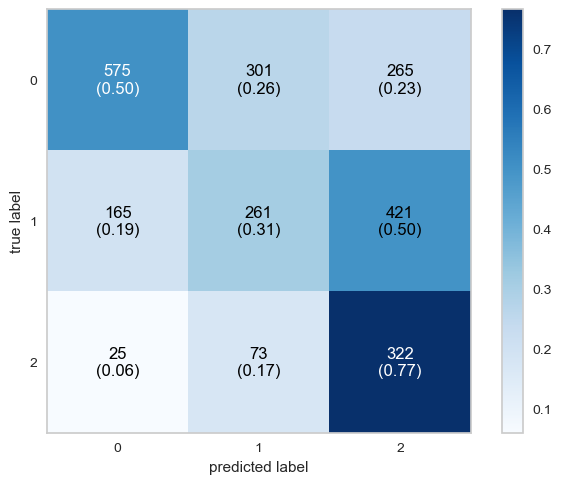

In [27]:
np.set_printoptions(suppress=True)
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

binary = matrix
fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [28]:
print(sklearn.metrics.classification_report(y_test_np, y_pred, labels=[0,1, 2]))


              precision    recall  f1-score   support

           0       0.75      0.50      0.60      1141
           1       0.41      0.31      0.35       847
           2       0.32      0.77      0.45       420

    accuracy                           0.48      2408
   macro avg       0.49      0.53      0.47      2408
weighted avg       0.56      0.48      0.49      2408



## LGBM Classifier

In [29]:
pca = PCA(5)
cl = LGBMClassifier(colsample_bytree=0.9 ,max_depth=4, learning_rate=0.1,min_child_samples=10,
              n_estimators=80, random_state=100,
              subsample=0.7, num_leaves=10)

scaler = StandardScaler()
pipe = Pipeline(steps=[("scaler", scaler), ("classficator", cl)])

In [30]:
pipe.fit(X_train_np, y_train_np)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 4887, number of used features: 14
[LightGBM] [Info] Start training from score -0.755410
[LightGBM] [Info] Start training from score -1.062442
[LightGBM] [Info] Start training from score -1.689719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Pipeline(steps=[('scaler', StandardScaler()),
                ('classficator',
                 LGBMClassifier(colsample_bytree=0.9, max_depth=4,
                                min_child_samples=10, n_estimators=80,
                                num_leaves=10, random_state=100,
                                subsample=0.7))])

In [31]:
y_pred = pipe.predict(X_test_np)

In [32]:
print(sklearn.metrics.classification_report(y_test_np, y_pred, labels=[0,1, 2]))

              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1141
           1       0.44      0.47      0.46       847
           2       0.58      0.30      0.39       420

    accuracy                           0.55      2408
   macro avg       0.55      0.49      0.51      2408
weighted avg       0.55      0.55      0.55      2408



In [33]:
matrix = sklearn.metrics.confusion_matrix(y_test_np, y_pred, labels=[0,1, 2])

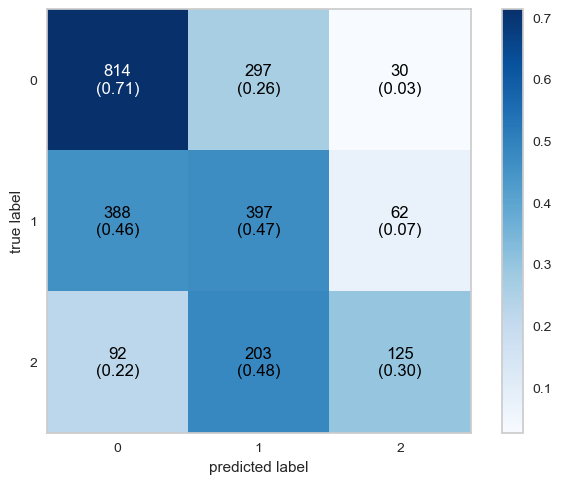

In [34]:
np.set_printoptions(suppress=True)
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

binary = matrix
fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

### Some comparison of tennis players

In [653]:
df_dummy[(df_dummy.name2=='Todd Woodbridge') & (df_dummy.name1=='Mark Woodforde')]

,name1,name2,success,success_cl,rank,hand,age_dif,country,height,relatives,Ace,DF,BP_saved,Ace_against,BP_won,Return_won,Point_dominance,Serve_rating,Game_time
7059,Mark Woodforde,Todd Woodbridge,0.864407,2,0,0,0.748779,1,1,0,0,0,1,2,2,2,2,1,0


In [651]:
df_dummy[(df_dummy.name2=='Bob Bryan') & (df_dummy.name1=='Mike Bryan')]

,name1,name2,success,success_cl,rank,hand,age_dif,country,height,relatives,Ace,DF,BP_saved,Ace_against,BP_won,Return_won,Point_dominance,Serve_rating,Game_time
7203,Mike Bryan,Bob Bryan,0.833333,2,0,0,0.0,1,2,1,1,2,0,0,2,0,0,1,0


In [655]:
df_mean[(df_mean.name2=='Bob Bryan') & (df_mean.name1=='Mike Bryan')]

,name1,name2,success,success_cl,rank,hand,age_dif,country,height,relatives,Ace,DF,BP_saved,Ace_against,BP_won,Return_won,Point_dominance,Serve_rating,Game_time
7203,Mike Bryan,Bob Bryan,0.833333,2,7.5,0,0.0,1,191.5,1,7.1,3.55,55.55,10.55,41.05,33.5,0.9,316.5,3.5


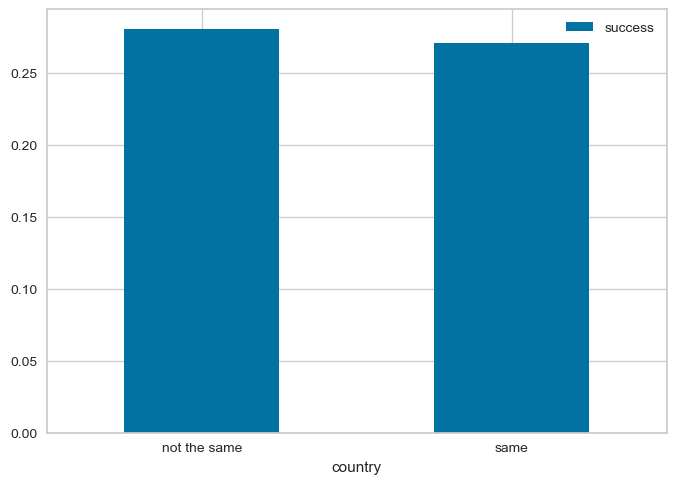

In [671]:
bar_graph = pd.DataFrame({'country':['not the same', 'same'], 'success':[df_mean[df_mean.country == 0]['success'].mean(),df_mean[df_mean.country == 1]['success'].mean()]})
ax = bar_graph.plot.bar(x='country', y='success', rot=0)

In [669]:
df_mean[df_mean.country == 1]['success'].mean()

0.27087242568118913

# Other Studies

### MLP Classifier by Somboonphokkaphan 


In [672]:
somboonphokkaphan = pd.read_csv('somboonphokkaphan.csv')

In [677]:
one_hot_encoded_data = pd.get_dummies(somboonphokkaphan, columns = ['surface'])
somboonphokkaphan = one_hot_encoded_data.drop(['tourney_level', 'entry', 'round', 'success'], axis=1)

In [682]:
somboonphokkaphan = somboonphokkaphan.dropna()

somboonphokkaphan['surface_Clay'] = somboonphokkaphan['surface_Clay'].astype('int')
somboonphokkaphan['surface_Grass'] = somboonphokkaphan['surface_Grass'].astype('int')
somboonphokkaphan['surface_Hard'] = somboonphokkaphan['surface_Hard'].astype('int')
somboonphokkaphan['surface_Carpet'] = somboonphokkaphan['surface_Carpet'].astype('int')

In [685]:
pl_set = set()
for i, row in somboonphokkaphan.iterrows():
    pl_set.add(row.name1)
    pl_set.add(row.name2)


In [823]:
all_stats = pd.read_csv('all_stats.csv')

In [705]:
import requests
from bs4 import BeautifulSoup
import urllib
import re
def get_stats_by_name(name, surname):
    stat_dict = {}
    site = f'https://www.ultimatetennisstatistics.com/playerProfile?name={name}+{surname}&tab=statistics'
    headers = {'Accept-Language': 'en', 'X-FORWARDED-FOR': '2.21.184.0'}
    response = requests.get(site, headers=headers)
    assert response.status_code == 200
    soup = BeautifulSoup(response.text)
    #print(soup)
    table = soup.find('a', attrs = {'data-toggle':"pill"})
    id = re.findall(r'[0-9]+', str(table))

    site = f'https://www.ultimatetennisstatistics.com/playerStatsTab?playerId={id[0]}'

    response = requests.get(site, headers=headers)
    assert response.status_code == 200
    soup = BeautifulSoup(response.text)
    stats = soup.find_all('tbody')
    try:
        stat_dict['first%'] = stats[0].find_all('th', attrs = {'class': "text-right pct-data"})[3].get_text()[:-1]
    except:
        stat_dict['first%'] = np.nan
    try:
        stat_dict['second%'] = stats[0].find_all('th', attrs = {'class': "text-right pct-data"})[4].get_text()[:-1]
    except:
        stat_dict['second%'] = np.nan
    try:
        stat_dict['Match_won'] = stats[2].find_all('th', attrs = {'class': "text-right"})[6].get_text()
    except:
        stat_dict['Match_won'] = np.nan

    return stat_dict

In [735]:
#stat_dict = {'first%': [],
#     'second%': [],
#     'Match_won': []}
for full_name in list(pl_set)[332:]:
    print('name:',full_name)
    try:
        name, surname= full_name.split()
    except:
        l = full_name.split()
        name = l[0] + ' ' + l[1]
        surname = l[2]
    cur_d = get_stats_by_name(name, surname)
    stat_dict['first%'].append(float(cur_d['first%']))
    stat_dict['second%'].append(float(cur_d['second%']))
    stat_dict['Match_won'].append((cur_d['Match_won']))



    if np.nan in list(cur_d.values()):
        print(name, surname)

    if i % 10== 0:
        print(i)

name: Danai Udomchoke
name: Martin Lee
name: Tomas Cakl
name: Dmitry Tursunov
name: Gael Monfils
name: Robin Vik
name: Julien Benneteau
name: Julien Jeanpierre
name: Goran Ivanisevic
name: Alejandro Falla
name: Nicklas Kulti
name: Jan Hajek
name: Somdev Devvarman
name: Galo Blanco
name: Chris Woodruff
name: Guido Pella
name: Mikhail Youzhny
name: Daniel Vacek
name: Rui Machado
name: Mark Merklein
name: Marius Copil
name: Ivan Navarro
name: Guy Forget
name: Eric Butorac
Eric Butorac
name: Ricardas Berankis
name: Michael Tebbutt
name: Paul Haarhuis
name: Thomas Johansson
name: Xavier Malisse
name: Philipp Petzschner
name: David Adams
name: Mikhail Kukushkin
name: Florin Mergea
name: Marcin Matkowski
name: Harel Levy
name: Arvind Parmar
name: Vincenzo Santopadre
name: Robert Lindstedt
name: James Ward
name: Nebojsa Djordjevic
Nebojsa Djordjevic
name: Dustin Brown
name: Kristof Vliegen
name: Marc Kevin Goellner
name: Rohan Bopanna
name: Jonathan Stark
name: Rajeev Ram
name: Gastao Elias
na

In [758]:
new_stats = pd.DataFrame(stat_dict)


In [759]:
new_stats['full_names'] = list(pl_set)

In [760]:
new_stats

,first%,second%,Match_won,full_names
0,66.0,49.0,919 / 2059,Denis Gremelmayr
1,74.4,50.0,14 / 30,Brent Haygarth
2,72.4,46.5,3275 / 6881,Justin Gimelstob
3,67.2,50.5,203 / 423,Simon Stadler
4,69.4,49.8,3567 / 7066,Luis Horna
...,...,...,...,...
618,75.1,48.5,1145 / 2439,Laurence Tieleman
619,69.8,48.2,245 / 560,Zack Fleishman
620,70.0,48.2,541 / 1239,Alex Bogdanovic
621,72.2,47.3,496 / 1078,Nenad Zimonjic


In [761]:
somboonphokkaphan= somboonphokkaphan.drop(['score_dif', 'hand1', 'hand2', 'height1', 'height2', 'age1', 'age2', 'ioc1', 'ioc2', 'rank1', 'rank2'], axis=1)

KeyError: "['score_dif', 'hand1', 'hand2', 'height1', 'height2', 'age1', 'age2', 'ioc1', 'ioc2', 'rank1', 'rank2'] not found in axis"

In [764]:
new= all_stats.merge(new_stats, how='inner', on='full_names')

In [767]:
new = new.drop(['Unnamed: 0', 'player_id', 'hand', 'dob', 'ioc', 'height', 'wikidata_id', 'Ace%', 'Ace_against%', 'Serve_rating', 'Game_time', 'BP_saved%'], axis=1)

In [770]:
somboonphokkaphan = somboonphokkaphan.merge(new, how='inner', left_on='name1', right_on='full_names')

In [774]:
somboonphokkaphan = somboonphokkaphan.rename(columns={"BP_won%": "BP_won%1", "Return_won%": "Return_won%1", 'Points_dominance': "Points_dominance1", 'first%':'first%1', 'second%': 'second%1', 'Match_won': 'Match_won1'}).drop(['DF%'], axis=1)

In [776]:
somboonphokkaphan = somboonphokkaphan.merge(new, how='inner', left_on='name2', right_on='full_names')

In [778]:
somboonphokkaphan = somboonphokkaphan.rename(columns={"BP_won%": "BP_won%2", "Return_won%": "Return_won%2", 'Points_dominance': "Points_dominance2", 'first%':'first%2', 'second%': 'second%2', 'Match_won': 'Match_won2'}).drop(['DF%'], axis=1)

In [781]:
somboonphokkaphan = somboonphokkaphan.drop(['pair', 'name_first_x', 'name_last_x' ,'name_first_y', 'name_last_y'], axis=1)

In [784]:
somboonphokkaphan = somboonphokkaphan.drop(['full_names_x', 'full_names_y'], axis=1)

In [797]:

match1 =[]
match2= []
for i, j in zip(somboonphokkaphan['Match_won1'], somboonphokkaphan['Match_won2']):
    try:
        a1, b1 = i.split(' / ')     
        m1 = int(a1) / int(b1)
    except:
        print(i)
        try:
            m1= float(1)
        except:
            m1 = float(i[:-1])
    try:
        a2, b2 = j.split(' / ')     
        m2 = int(a2) / int(b2)
    except:
        print(j)
        try:
            m2= float(j)
        except:
            m2 = float(j[:-1])
    
    match1.append(m1)
    match2.append(m2)

0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
nan
0.00
nan
0.00
nan
0.00
nan
0.00
nan
0.00
nan
0.00
nan
0.00
nan
0.00
nan
0.00
nan
0.00
nan
0.00
nan
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
1.00
nan
nan
nan
nan
nan
nan
0.00
0.00
0.00
0.0

In [798]:
somboonphokkaphan['Match_won1'] = match1
somboonphokkaphan['Match_won2'] = match2

In [799]:
somboonphokkaphan['BP_won'] = (somboonphokkaphan['BP_won%1'] + somboonphokkaphan['BP_won%2']) / 2
somboonphokkaphan['first'] = (somboonphokkaphan['first%1'] + somboonphokkaphan['first%2']) / 2
somboonphokkaphan['second'] = (somboonphokkaphan['second%1'] + somboonphokkaphan['second%2']) / 2
somboonphokkaphan['Return_won'] = (somboonphokkaphan['Return_won%1'] + somboonphokkaphan['Return_won%2']) / 2
somboonphokkaphan['Match_won'] = (somboonphokkaphan['Match_won1'] + somboonphokkaphan['Match_won2']) / 2
somboonphokkaphan['Point_dominance'] = (somboonphokkaphan['Points_dominance1'] + somboonphokkaphan['Points_dominance2']) / 2


In [805]:
somboonphokkaphan= somboonphokkaphan.drop(['BP_won%1', 'BP_won%2', 'first%1', 'first%2', 'second%1', 'second%2', 'Return_won%1', 'Return_won%2', 'Match_won1', 'Match_won2', 'Points_dominance1', 'Points_dominance2'], axis=1).dropna()

In [874]:
somboonphokkaphan.to_csv('somboonphokkaphan.csv', index=False)

In [815]:
pca = PCA(5)
reg = LGBMRegressor(colsample_bytree=0.9 ,max_depth=4, learning_rate=0.1,min_child_samples=10,
              n_estimators=80, objective='regression', random_state=100,
              subsample=0.7, num_leaves=10)
cl = MLPClassifier(hidden_layer_sizes=(50,),learning_rate_init=0.3,momentum=0.2 )
scaler = StandardScaler()
pipe = Pipeline(steps=[("scaler", scaler), ("classficator", cl)])
y = somboonphokkaphan['win']
X = somboonphokkaphan.drop(['win' ,'name1', 'name2'], axis=1)
#X = df_mean[['age_dif', 'Ace', 'Game_time', 'height', 'DF', 'relatives']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [816]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classficator',
                 MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.3,
                               momentum=0.2))])

In [817]:
y_pred = pipe.predict(X_test)

In [818]:
accuracy_score(y_test, y_pred)

0.5212897891690781

In [819]:
matrix = sklearn.metrics.confusion_matrix(y_test, y_pred, labels=[0,1])

In [820]:
matrix

array([[ 124, 1061],
       [  97, 1137]], dtype=int64)

In [822]:
somboonphokkaphan.win.value_counts()

win
1    3812
0    3518
Name: count, dtype: int64

###  Vombatkere Logistic/Neural

In [827]:
matches_by_pairs = pd.read_csv('matches_by_pairs.csv')

In [828]:
matches_by_pairs = matches_by_pairs.drop(['pair', 'score_dif','tourney_level', 'entry', 'round', 'hand1', 'hand2', 'age1', 'age2', 'ioc1', 'ioc2', 'rank1', 'rank2'], axis=1)

In [830]:
pl_set = set()
for i, row in matches_by_pairs.iterrows():
    pl_set.add(row.name1)
    pl_set.add(row.name2)

In [831]:
len(pl_set)

1800

In [867]:
import requests
from bs4 import BeautifulSoup
import urllib
import re
def get_stats_by_name(name, surname):
    stat_dict = {}
    site = f'https://www.ultimatetennisstatistics.com/playerProfile?name={name}+{surname}&tab=statistics'
    headers = {'Accept-Language': 'en', 'X-FORWARDED-FOR': '2.21.184.0'}
    response = requests.get(site, headers=headers)
    assert response.status_code == 200
    soup = BeautifulSoup(response.text)
    #print(soup)
    table = soup.find('a', attrs = {'data-toggle':"pill"})
    id = re.findall(r'[0-9]+', str(table))

    site = f'https://www.ultimatetennisstatistics.com/playerStatsTab?playerId={id[0]}&tab=matches&season=&fromDate=&toDate=&level=&bestOf=&surface=&indoor=&speed=&round=&result=&tournamentId=&opponent=TOP_20&countryId=&outcome=played'
    response = requests.get(site, headers=headers)
    assert response.status_code == 200
    soup = BeautifulSoup(response.text)
    stats = soup.find_all('tbody')

    try:
        stat_dict['top20%'] = stats[0].find_all('th', attrs = {'class': "text-right pct-data"})[2].get_text()[:-1]
    except:
        stat_dict['top20%'] = np.nan

    site = f'https://www.ultimatetennisstatistics.com/playerStatsTab?playerId={id[0]}&tab=matches&season=&fromDate=&toDate=&level=&bestOf=&surface=&indoor=&speed=&round=&result=&tournamentId=&opponent=TOP_100&countryId=&outcome=played'
    response = requests.get(site, headers=headers)
    assert response.status_code == 200
    soup = BeautifulSoup(response.text)
    stats = soup.find_all('tbody')
    try:
        stat_dict['top100%'] = stats[0].find_all('th', attrs = {'class': "text-right pct-data"})[2].get_text()[:-1]
    except:
        stat_dict['top100%'] = np.nan

    return stat_dict

In [868]:
get_stats_by_name('Rafael', 'Nadal')

{'top20%': '68.9', 'top100%': '68.3'}

In [873]:
stat_dict = {'top20%': [],
    'top100%': []}
count = 0
for full_name in list(pl_set):
    count +=1
    try:
        name, surname= full_name.split()
    except:
        l = full_name.split()
        name = l[0] + ' ' + l[1]
        surname = l[2]
    cur_d = get_stats_by_name(name, surname)
    try:
        stat_dict['top20%'].append(float(cur_d['top20%']))
    except:
        print(cur_d['top20%'])
        stat_dict['top20%'].append(float(cur_d['top20%'][:-1])/100)
        print(float(cur_d['top20%'][:-1])/100)
    try:
        stat_dict['top100%'].append(float(cur_d['top100%']))
    except:
        print(cur_d['top100%'])
        stat_dict['top100%'].append(float(cur_d['top100%'][:-1])/100)
        print(float(cur_d['top100%'][:-1])/100)

    if count % 100== 0:
        print(count)


0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0
100

33.3%
0.33299999999999996

0.0%
0.0

0.0%
0.0
200

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0

22.2%
0.222

0.0%
0.0
300

0.0%
0.0

0.0%
0.0

0.0%
0.0
400

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0

50.0%
0.5
500

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0
600

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0
700

22.7%
0.22699999999999998

45.8%
0.45799999999999996

33.3%
0.33299999999999996

0.0%
0.0

0.0%
0.0

0.0%
0.0
800

0.0%
0.0

0.0%
0.0

0.0%
0.0
900

0.0%
0.0

0.0%
0.0

0.0%
0.0
1000

0.0%
0.0

0.0%
0.0

0.0%
0.0
1100

0.0%
0.0

0.0%
0.0

0.0%
0.0
1200

0.0%
0.0

0.0%
0.0

0.0%
0.0
1300

0.0%
0.0

16.7%
0.16699999999999998

0.0%
0.0
1400

0.0%
0.0

0.0%
0.0
1500

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0
1600

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0
1700

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0

0.0%
0.0
1800


In [875]:
len(stat_dict['top20%'])

1800

In [878]:
#pd.DataFrame(stat_dict).to_csv('stats_serves.csv', index=False)
stats_serves = pd.read_csv('stats_serves.csv')

In [885]:
new_stats = pd.concat([stats_serves, pd.DataFrame(stat_dict)], axis=1, sort=False)

In [886]:
new_stats['full_names'] = list(pl_set)

In [887]:
new= all_stats.merge(new_stats, how='inner', on='full_names')

In [888]:
new

,Unnamed: 0,player_id,name_first,name_last,hand,dob,ioc,height,wikidata_id,full_names,...,Return_won%,Points_dominance,Serve_rating,Game_time,first%,first_won%,second_won%,Match_won,top20%,top100%
0,0,100431,Mansour,Bahrami,R,19560426.0,IRI,178.0,Q564631,Mansour Bahrami,...,35.1,0.81,289.0,3.62,61.2,65.6,42.4,1203 / 2550,0.0,60.0
1,1,100581,John,McEnroe,L,19590216.0,USA,180.0,Q16474,John Mcenroe,...,39.4,1.11,328.0,4.63,56.5,75.5,50.1,15467 / 25987,58.6,57.0
2,2,100644,Alexander,Zverev,R,19970420.0,GER,198.0,Q13990552,Alexander Zverev,...,38.3,1.12,338.0,4.21,65.6,74.2,49.7,7734 / 14368,67.0,65.9
3,3,100757,Anders,Jarryd,R,19610713.0,SWE,180.0,Q455136,Anders Jarryd,...,39.2,1.03,307.0,3.96,54.3,71.9,49.7,8144 / 15253,52.6,53.4
4,4,100819,Daniel,Montes De Oca,R,19620426.0,URU,170.0,Q107986458,Daniel Montes De Oca,...,NaN,1.00,NaN,NaN,0.0,NaN,NaN,0.20,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,1797,209080,Blaise,Bicknell,R,20011126.0,USA,188.0,Q96678039,Blaise Bicknell,...,NaN,1.00,NaN,NaN,0.5,NaN,NaN,0.50,NaN,NaN
1796,1798,209238,Sebastian,Dominguez,NaN,20020622.0,GUA,NaN,NaN,Sebastian Dominguez,...,NaN,0.00,NaN,NaN,0.0,NaN,NaN,0.00,NaN,0.0
1797,1799,209327,Rashed,Nawaf,R,20050601.0,QAT,NaN,Q81217332,Rashed Nawaf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1798,1800,209866,Karlis,Ozolins,R,20020615.0,LAT,NaN,Q88330726,Karlis Ozolins,...,NaN,1.00,NaN,NaN,0.0,NaN,NaN,1.00,NaN,NaN


In [889]:
new = new.drop(['Unnamed: 0', 'player_id', 'hand', 'dob', 'ioc', 'wikidata_id', 'Ace_against%', 'Serve_rating', 'Game_time'], axis=1)

In [891]:
new = new.drop(['Return_won%', 'Points_dominance'], axis=1)

In [901]:
vombatkere = matches_by_pairs.merge(new, how='inner', left_on='name1', right_on='full_names')

In [902]:
vombatkere

,win,name1,name2,height1,height2,name_first,name_last,height,full_names,Ace%,DF%,BP_saved%,BP_won%,first%,first_won%,second_won%,Match_won,top20%,top100%
0,0,Yacoub Makzoume,Hazem Naw,NaN,NaN,Yacoub,Makzoume,NaN,Yacoub Makzoume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Benjamin Lock,Courtney John Lock,NaN,NaN,Benjamin,Lock,198.0,Benjamin Lock,5.1,2.2,56.3,43.5,64.30,63.4,47.4,122 / 218,NaN,61.3
2,0,Ching Lam,Pak Long Yeung,NaN,NaN,Ching,Lam,NaN,Ching Lam,20.0,0.0,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN
3,1,Szymon Walkow,Jan Zielinski,NaN,NaN,Szymon,Walkow,NaN,Szymon Walkow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Markos Kalovelonis,Petros Tsitsipas,NaN,NaN,Markos,Kalovelonis,191.0,Markos Kalovelonis,41.5,42.9,NaN,NaN,0.50,NaN,NaN,1.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52767,0,Andrew Painter,Jocelyn Robichaud,188.0,NaN,Andrew,Painter,188.0,Andrew Painter,9.4,14.5,46.2,0.0,44.40,71.2,23.1,5 / 23,44.4,44.4
52768,0,Jonathan Beardsley,Mike Passarella,NaN,NaN,Jonathan,Beardsley,NaN,Jonathan Beardsley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52769,0,Rene Nicklisch,Tomas Nydahl,NaN,185.0,Rene,Nicklisch,NaN,Rene Nicklisch,0.0,5.9,28.6,0.0,64.70,48.5,33.3,2 / 14,NaN,64.7
52770,1,James Shortall,Cristiano Testa,NaN,NaN,James,Shortall,NaN,James Shortall,44.2,30.0,NaN,NaN,0.25,NaN,NaN,0.50,NaN,NaN


In [903]:
vombatkere = vombatkere.rename(columns={"BP_won%": "BP_won%1","BP_saved%": "BP_saved%1" ,"Ace%": "Ace%1", 'DF%': "DF%1", 'first%':'first%1','first_won%':'first_won%1', 'second_won%': 'second_won%1', 'Match_won': 'Match_won1', 'top20%': 'top20%1', 'top100%': 'top100%'})

In [904]:
vombatkere = vombatkere.drop(['height1', 'height2'], axis=1)
vombatkere = vombatkere.rename(columns={'height': 'height1'})


In [905]:
vombatkere = vombatkere.merge(new, how='inner', left_on='name2', right_on='full_names')

In [907]:
vombatkere = vombatkere.rename(columns={"BP_won%": "BP_won%2","BP_saved%": "BP_saved%2" ,"Ace%": "Ace%2", 'DF%': "DF%2", 'first%':'first%2','first_won%':'first_won%2', 'second_won%': 'second_won%2', 'Match_won': 'Match_won2', 'top20%': 'top20%2', 'top100%_x': 'top100%1', 'top100%_y': 'top100%2'})

In [912]:
vombatkere = vombatkere.drop(['name_first_x', 'name_first_y', 'name_last_x', 'name_last_y', 'full_names_x', 'full_names_y'], axis=1)

In [916]:
match1 =[]
match2= []
for i, j in zip(vombatkere['Match_won1'], vombatkere['Match_won2']):
    try:
        a1, b1 = i.split(' / ')     
        m1 = int(a1) / int(b1)
    except:
        try:
            m1= float(1)
        except:
            m1 = float(i[:-1])
    try:
        a2, b2 = j.split(' / ')     
        m2 = int(a2) / int(b2)
    except:
        try:
            m2= float(j)
        except:
            m2 = float(j[:-1])
    
    match1.append(m1)
    match2.append(m2)

In [917]:
vombatkere['Match_won1'] = match1
vombatkere['Match_won2'] = match2

In [918]:
vombatkere['BP_won'] = (vombatkere['BP_won%1'] + vombatkere['BP_won%2']) / 2
vombatkere['BP_saved'] = (vombatkere['BP_saved%1'] + vombatkere['BP_saved%2']) / 2
vombatkere['first'] = (vombatkere['first%1'] + vombatkere['first%2']) / 2
vombatkere['second_won'] = (vombatkere['second_won%1'] + vombatkere['second_won%2']) / 2
vombatkere['first_won'] = (vombatkere['first_won%1'] + vombatkere['first_won%2']) / 2
vombatkere['Match_won'] = (vombatkere['Match_won1'] + vombatkere['Match_won2']) / 2
vombatkere['top20'] = (vombatkere['top20%1'] + vombatkere['top20%2']) / 2
vombatkere['top100'] = (vombatkere['top100%1'] + vombatkere['top100%2']) / 2
vombatkere['A/DF'] = (vombatkere['Ace%1'] /vombatkere['DF%1']  + vombatkere['Ace%2'] /vombatkere['DF%2']) / 2

In [923]:
vombatkere= vombatkere.drop(['BP_won%1', 'BP_won%2', 'BP_saved%1', 'BP_saved%2','first%1', 'first%2', 'first_won%1', 'first_won%2','second_won%1', 'second_won%2','second_won','height1','height','top20%1', 'top20%2', 'Match_won1', 'Match_won2', 'top100%1', 'top100%2', 'Ace%1', 'Ace%2', 'DF%1', 'DF%2'], axis=1).dropna()

In [925]:
vombatkere = vombatkere.dropna()

In [927]:
vombatkere

,win,name1,name2,BP_won,BP_saved,first,first_won,Match_won,top20,top100,A/DF
11,0,Malek Jaziri,Lamine Ouahab,42.15,58.55,54.85,68.75,0.488881,59.15,54.95,0.983740
25,0,Ernests Gulbis,Dominic Thiem,38.20,63.40,60.35,74.45,0.517002,61.10,60.45,2.141779
26,0,Joao Sousa,Dominic Thiem,38.35,60.45,60.75,71.55,0.504860,60.40,60.70,1.850000
27,0,Oliver Marach,Dominic Thiem,39.10,61.20,58.05,71.05,0.492673,56.00,58.45,1.812355
28,0,Oliver Marach,Dominic Thiem,39.10,61.20,58.05,71.05,0.492673,56.00,58.45,1.812355
...,...,...,...,...,...,...,...,...,...,...,...
52740,0,Sultan Khalfan,Nasser Ghanim Al Khulaifi,66.15,30.10,52.25,45.45,0.331152,52.35,54.55,0.163068
52744,1,Miguel Tobon,Juan Albert Viloca Puig,39.90,58.70,58.05,70.85,0.476761,28.65,58.55,1.231832
52745,0,Miguel Tobon,Juan Albert Viloca Puig,39.90,58.70,58.05,70.85,0.476761,28.65,58.55,1.231832
52758,0,Arnaud Di Pasquale,Rodolphe Gilbert,40.30,57.05,57.45,67.60,0.477841,57.00,57.35,1.144452


In [939]:
pca = PCA(5)
reg = LogisticRegression(solver='liblinear')
scaler = StandardScaler()
pipe = Pipeline(steps=[("scaler", scaler), ("classficator", reg)])
y = vombatkere['win']
X = vombatkere.drop(['win' ,'name1', 'name2', 'BP_won', ], axis=1)
#X = df_mean[['age_dif', 'Ace', 'Game_time', 'height', 'DF', 'relatives']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [940]:
pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classficator', LogisticRegression(solver='liblinear'))])

In [941]:
y_pred = pipe.predict(X_test)
accuracy_score(y_test, y_pred)

0.5495190205509402

In [935]:
pca = PCA(5)
cl = MLPClassifier(learning_rate_init=0.01, solver='sgd')
scaler = StandardScaler()
pipe = Pipeline(steps=[("scaler", scaler), ("classficator", cl)])
y = vombatkere['win']
X = vombatkere.drop(['win' ,'name1', 'name2', 'first'], axis=1)
#X = df_mean[['age_dif', 'Ace', 'Game_time', 'height', 'DF', 'relatives']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [936]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classficator',
                 MLPClassifier(learning_rate_init=0.01, solver='sgd'))])

In [937]:
y_pred = pipe.predict(X_test)
accuracy_score(y_test, y_pred)

0.5694140795802362

In [942]:
print(sklearn.metrics.classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.56      0.51      0.53      4586
           1       0.54      0.59      0.57      4562

    accuracy                           0.55      9148
   macro avg       0.55      0.55      0.55      9148
weighted avg       0.55      0.55      0.55      9148

